In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [12]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)   #H0= hubble parameter today in km/s    ombh2=physical density in baryons omch2=physical density in cold dark matter
#trovo densità diverse...
pars.InitPower.set_params(ns=0.965)  #ns = scalar spectra index (inflaction)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0., 0.8], kmax=2.0)  #??

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)   #crea un oggetto results a partire dai dati iniziali
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)

Note: redshifts have been re-sorted (earliest first)


Domande, 
1) cosa centra lo spettro di potenza calcolato a diverse z?
2) lineare e non lineare?
3) non è che i comandi si assomigliano tanto ne

In [8]:
print(results.get_sigma8())

[0.53298468 0.80251083]


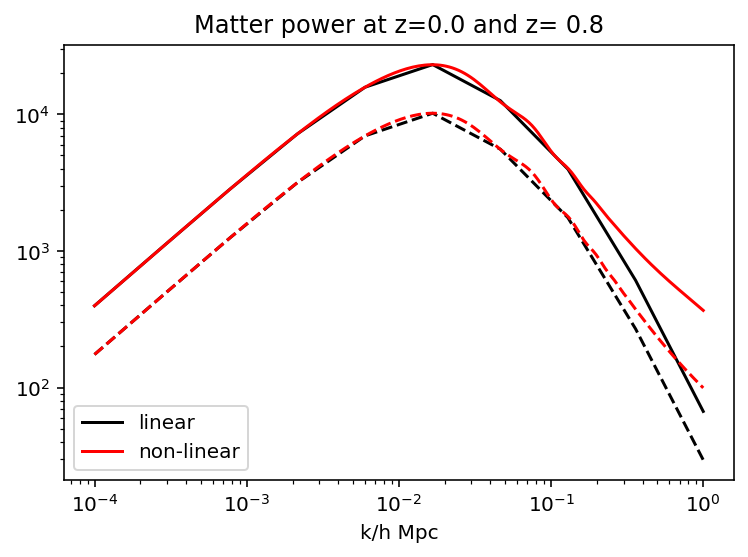

In [11]:
for i, (redshift, line) in enumerate(zip(z,['-','--'])): #cicla sulle z e sulle righette. Ogni grafico ha una zeta e una lineetta diversa
    plt.loglog(kh, pk[i,:], color='k', ls = line)
    #plt.loglog(kh_nonlin, pk_nonlin[i,:], color='r', ls = line)
plt.xlabel('k/h Mpc');
plt.legend(['linear','non-linear'], loc='lower left');
plt.title('Matter power at z=%s and z= %s'%tuple(z));

I fotoni del background vengono deviati dalle masse dell'universo (lensing gravitazionale) e quindi lo spettro  di potenza appare sbagliato.

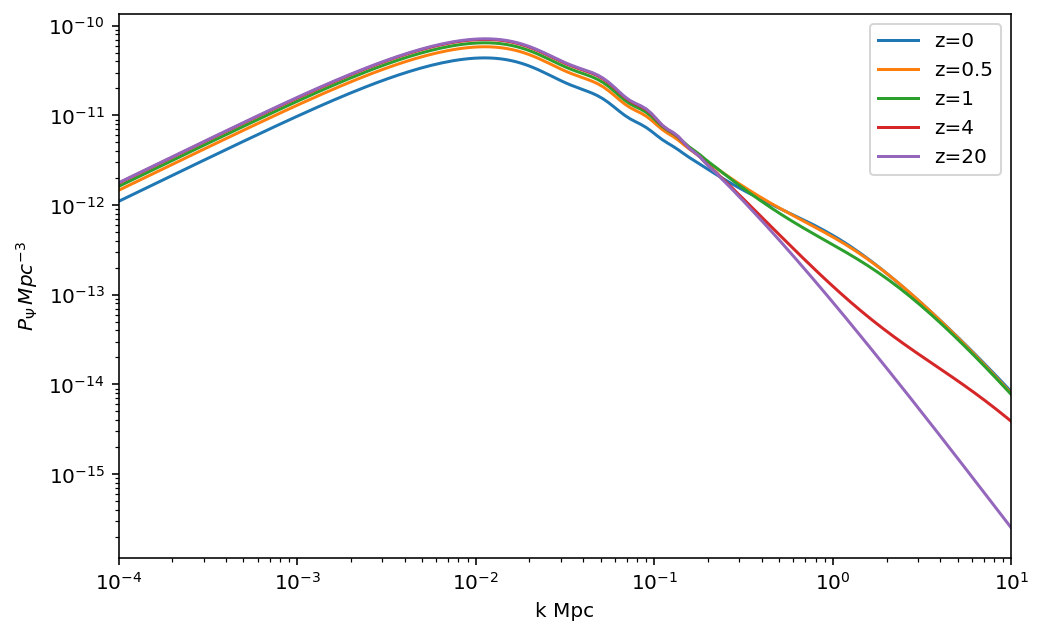

In [8]:
#For calculating large-scale structure and lensing results yourself, get a power spectrum
#interpolation object. In this example we calculate the CMB lensing potential power
#spectrum using the Limber approximation, using PK=camb.get_matter_power_interpolator() function.
#calling PK(z, k) will then get power spectrum at any k and redshift z in range.

nz = 100 #number of steps to use for the radial/redshift integration
kmax=10  #kmax to use
#First set up parameters as usual
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)

#For Limber result, want integration over \chi (comoving radial distance), from 0 to chi_*.
#so get background results to find chistar, set up a range in chi, and calculate corresponding redshifts
results= camb.get_background(pars)
chistar = results.conformal_time(0)- results.tau_maxvis
chis = np.linspace(0,chistar,nz)
zs=results.redshift_at_comoving_radial_distance(chis)
#Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]

#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#Here for lensing we want the power spectrum of the Weyl potential.
PK = camb.get_matter_power_interpolator(pars, nonlinear=True, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_Weyl,var2=model.Transfer_Weyl, zmax=zs[-1])

#Have a look at interpolated power spectrum results for a range of redshifts
#Expect linear potentials to decay a bit when Lambda becomes important, and change from non-linear growth
plt.figure(figsize=(8,5))
k=np.exp(np.log(10)*np.linspace(-4,2,200))
zplot = [0, 0.5, 1, 4 ,20]
for z in zplot:
    plt.loglog(k, PK.P(z,k))
plt.xlim([1e-4,kmax])
plt.xlabel('k Mpc')
plt.ylabel('$P_\Psi\, Mpc^{-3}$')
plt.legend(['z=%s'%z for z in zplot]);

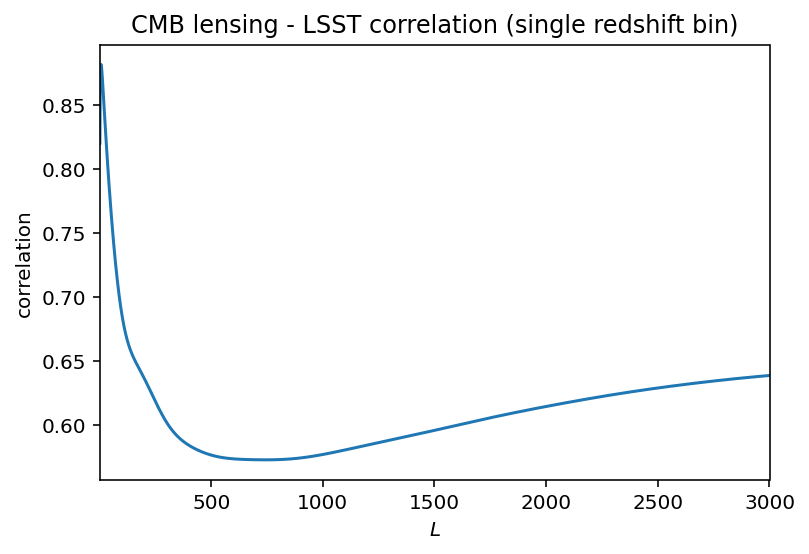

In [11]:
# For number counts you can give a redshift-dependent bias (the underlying code supports general b(z,k))
# toy model for single-bin LSST/Vera Rubin [using numbers from 1705.02332]
z0=0.311
zs = np.arange(0, 10, 0.02)
W = np.exp(-zs/z0)*(zs/z0)**2/2/z0
bias = 1 + 0.84*zs
pars.SourceWindows = [SplinedSourceWindow(dlog10Ndm=0, z=zs, W=W, bias_z = bias)]
lmax=3000
pars.set_for_lmax(lmax, lens_potential_accuracy=5)
results = camb.get_results(pars)

#e.g. plot the cross-correlation with CMB lensing
cls = results.get_cmb_unlensed_scalar_array_dict()

nbar = 40/(np.pi/180/60)**2 # Poission noise
ls= np.arange(2,lmax+1)
Dnoise = 1/nbar*ls*(ls+1)/2/np.pi

correlation=cls["PxW1"][2:lmax+1]/np.sqrt(cls["PxP"][2:lmax+1]*(cls["W1xW1"][2:lmax+1]+Dnoise))
plt.plot(np.arange(2,lmax+1), correlation)
plt.xlabel(r'$L$')
plt.ylabel('correlation')
plt.xlim(2,lmax)
plt.title('CMB lensing - LSST correlation (single redshift bin)');